[INFO] Loaded Maths.csv as Excel, shape=(397, 33)
[INFO] Loaded Portuguese.csv as Excel, shape=(651, 33)
[INFO] Combined shape: (1048, 33)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

=== Recomputed Test Accuracy: 0.8000
[INFO] classification_report.txt saved in C:\Users\sagni\Downloads\Dynamic Curriculum Designer


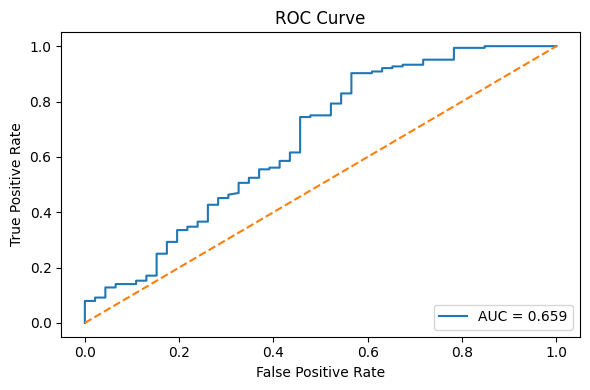

[INFO] Saved ROC curve -> C:\Users\sagni\Downloads\Dynamic Curriculum Designer\roc_curve.png


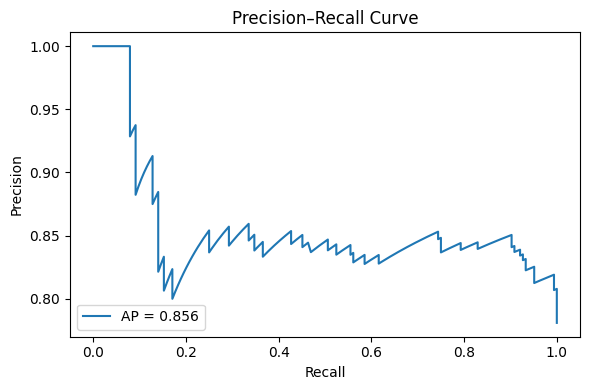

[INFO] Saved PR curve -> C:\Users\sagni\Downloads\Dynamic Curriculum Designer\pr_curve.png
[INFO] Saved metrics.json in C:\Users\sagni\Downloads\Dynamic Curriculum Designer


In [1]:
import os, csv, json, pickle, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    classification_report, accuracy_score
)

import tensorflow as tf

# ---------- Paths (yours) ----------
DATA_MATHS = r"C:\Users\sagni\Downloads\Dynamic Curriculum Designer\archive (1)\Maths.csv"
DATA_PORT  = r"C:\Users\sagni\Downloads\Dynamic Curriculum Designer\archive (1)\Portuguese.csv"
OUTPUT_DIR = r"C:\Users\sagni\Downloads\Dynamic Curriculum Designer"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------- Helper: detect Excel by 'PK' magic ----------
def is_zip_or_xlsx(path):
    try:
        with open(path, "rb") as f:
            return f.read(2) == b"PK"
    except Exception:
        return False

# ---------- Robust reader (Excel first if needed, else CSV with enc/sep tries) ----------
def robust_read_any(path):
    if not os.path.exists(path):
        print(f"[ERROR] Missing file: {path}")
        return None
    if is_zip_or_xlsx(path):
        try:
            import openpyxl  # ensure installed
            df = pd.read_excel(path, engine="openpyxl")
            print(f"[INFO] Loaded {os.path.basename(path)} as Excel, shape={df.shape}")
            return df
        except Exception as e:
            print(f"[WARN] Excel read failed: {e}")

    encodings = ["utf-8", "utf-8-sig", "cp1252", "latin1"]
    delimiters = [";", ",", "\t", "|"]
    try:
        with open(path, "rb") as f:
            head = f.read(4096).decode("latin1", errors="ignore")
        try:
            sniff = csv.Sniffer().sniff(head)
            if sniff.delimiter in delimiters:
                delimiters = [sniff.delimiter] + [d for d in delimiters if d != sniff.delimiter]
        except Exception:
            pass
    except Exception:
        pass

    last_err = None
    for enc in encodings:
        for sep in delimiters:
            try:
                df = pd.read_csv(path, encoding=enc, sep=sep, engine="python")
                if df.shape[1] > 1:
                    print(f"[INFO] Loaded {os.path.basename(path)} as CSV enc='{enc}', sep='{sep}', shape={df.shape}")
                    return df
            except Exception as e:
                last_err = e
                continue
    print(f"[ERROR] Could not read {path}. Last error: {last_err}")
    return None

# ---------- Load & combine ----------
df_m = robust_read_any(DATA_MATHS)
df_p = robust_read_any(DATA_PORT)
if df_m is None or df_p is None:
    raise FileNotFoundError("Failed to load Maths/Portuguese after robust attempts.")

common_cols = sorted(set(df_m.columns).intersection(set(df_p.columns)))
if not common_cols:
    raise ValueError("No common columns between Maths and Portuguese.")
df = pd.concat([df_m[common_cols], df_p[common_cols]], ignore_index=True)
print("[INFO] Combined shape:", df.shape)

# ---------- Target: PASS if G3 >= 10 ----------
if "G3" not in df.columns:
    raise ValueError("Column 'G3' missing. Check your files.")
df = df.dropna(subset=["G3"]).copy()
df["target"] = (pd.to_numeric(df["G3"], errors="coerce") >= 10).astype(int)
for c in ["G1", "G2", "G3"]:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

# ---------- Feature typing ----------
cat_cols = [c for c in df.columns if df[c].dtype == "object" and c != "target"]
num_cols = [c for c in df.columns if c not in cat_cols + ["target"]]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=num_cols)

X = df[cat_cols + num_cols]
y = df["target"].astype(int).values

# Recreate the split (same random_state as training cell)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------- Load preprocessor + align columns ----------
with open(os.path.join(OUTPUT_DIR, "preprocessor.pkl"), "rb") as f:
    preproc = pickle.load(f)

# Expect these raw input columns (in this order)
cat_cols_expected = list(preproc.transformers_[0][2])
num_cols_expected = list(preproc.transformers_[1][2])
expected_cols = cat_cols_expected + num_cols_expected

# Reorder/current-data to match what preprocessor expects
for col in expected_cols:
    if col not in X.columns:
        X[col] = np.nan
X = X[expected_cols]
X_train = X.loc[X_train.index]
X_test  = X.loc[X_test.index]

# Transform using the *loaded, already-fitted* preprocessor
X_test_proc = preproc.transform(X_test)

# ---------- Load model (.keras preferred; .h5 fallback) ----------
model_path_keras = os.path.join(OUTPUT_DIR, "model.keras")
model_path_h5    = os.path.join(OUTPUT_DIR, "model.h5")
try:
    mdl = tf.keras.models.load_model(model_path_keras)
except Exception:
    mdl = tf.keras.models.load_model(model_path_h5)

# (Optional) compile so evaluate() has metrics (silences the absl note)
mdl.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# ---------- Predictions & metrics ----------
y_pred_prob = mdl.predict(X_test_proc).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
print(f"\n=== Recomputed Test Accuracy: {acc:.4f}")

report = classification_report(y_test, y_pred)
with open(os.path.join(OUTPUT_DIR, "classification_report.txt"), "w", encoding="utf-8") as f:
    f.write(report)
print(f"[INFO] classification_report.txt saved in {OUTPUT_DIR}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
roc_path = os.path.join(OUTPUT_DIR, "roc_curve.png")
plt.tight_layout()
plt.savefig(roc_path, dpi=150)
plt.show()
print(f"[INFO] Saved ROC curve -> {roc_path}")

# Precision–Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap = average_precision_score(y_test, y_pred_prob)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="lower left")
pr_path = os.path.join(OUTPUT_DIR, "pr_curve.png")
plt.tight_layout()
plt.savefig(pr_path, dpi=150)
plt.show()
print(f"[INFO] Saved PR curve -> {pr_path}")

# Save a small metrics bundle
with open(os.path.join(OUTPUT_DIR, "metrics.json"), "w", encoding="utf-8") as f:
    json.dump({"accuracy": float(acc), "roc_auc": float(roc_auc), "average_precision": float(ap)}, f, indent=2)
print(f"[INFO] Saved metrics.json in {OUTPUT_DIR}")
